In [5]:
import requests
import json

def get_tweets(year):
    #  the truly excellent Trump Twitter Archive, which contains all of Trump’s tweets going back to 2009.
    url = ('http://www.trumptwitterarchive.com/data/realdonaldtrump/%s.json' %year)
    r = requests.get(url)
    print(str(year) + ' --> ' + 'done.')
    return r.json()

def save_tweets(years=range(2010,2020)):
        
        tweets = []
        for y in years:
            data = get_tweets(y)
            dl = len(data)
            
            i = 0
            while i < dl:
                tweets.append(data[i])
                i += 1
                
        return tweets
    
with open("trump_tweets_2010~2020.json", "w", encoding="utf-8") as outfile:
    json.dump(save_tweets(), outfile)
    print('done')

2010 --> done.
2011 --> done.
2012 --> done.
2013 --> done.
2014 --> done.
2015 --> done.
2016 --> done.
2017 --> done.
2018 --> done.
2019 --> done.
done


In [6]:
# make dataframe from JSON data
import pandas as pd
df = pd.read_json('trump_tweets_2010~2020.json')
df.shape

(42925, 9)

In [7]:
df.tail()

,created_at,favorite_ccount,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
42920,2019-01-01 12:51:34,NaN,76622.0,1080084113762197504,NaN,False,14059,Twitter for iPhone,"Dr. Sebastian Gorka, a very good and talented ..."
42921,2019-01-01 02:01:26,NaN,0.0,1079920504268562432,NaN,False,25861,Twitter for iPhone,RT @WhiteHouse: 2018 has been a year of histor...
42922,2019-01-01 01:05:39,NaN,135209.0,1079906462753869824,NaN,False,28529,Twitter for iPhone,...Remember this. Throughout the ages some thi...
42923,2019-01-01 00:51:43,NaN,99239.0,1079902957938925568,NaN,False,22897,Twitter for iPhone,"The Democrats will probably submit a Bill, bei..."
42924,2019-01-01 00:40:26,NaN,104440.0,1079900120047603712,NaN,False,23882,Twitter for iPhone,MEXICO IS PAYING FOR THE WALL through the many...


In [8]:
# extract the mean of lenghts:
import numpy as np
mean = np.mean([len(i) for i in df.text])

print("The lenght's average in tweets: %.2f%%" % mean)

The lenght's average in tweets: 124.57%


In [9]:
# use TweetTokenizer to tokenise a Tweet Text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

def tokenizer_tweets(df):
    
    text = ''
    for t in df['text']:
        text += t
    tokens = [i.lower() for i in tknzr.tokenize(text)]
    
    return tokens

tokens = tokenizer_tweets(df)
print(len(tokens))
print(tokens[:20])

992533
['wishing', 'everyone', 'a', 'happy', ',', 'healthy', 'and', 'prosperous', 'new', 'year', '!', 'wishing', 'everyone', 'a', 'very', 'happy', 'holiday', 'season', '!', "don't"]


In [23]:
# remove stop words and other noise(links and special characters) to get clear tokens
from nltk.corpus import stopwords
import string

punctiuation = list(string.punctuation)
stop = stopwords.words('english') + punctiuation

def clear_tokens(tokens):
    
    tokens_cl = [t for t in tokens if (len(t) >= 3) 
                 and (not t.startswith(('#', '@')))
                 and (not t.startswith('http'))
                 and (t not in stop)
                 and (t[0].isalpha())]
    
    return tokens_cl

tokens_cl = clear_tokens(tokens)
print(len(tokens_cl))
print(tokens_cl[:20])

400084
['wishing', 'everyone', 'happy', 'healthy', 'prosperous', 'new', 'year', 'wishing', 'everyone', 'happy', 'holiday', 'season', 'forget', 'watch', 'larry', 'king', 'tonight', 'cnn', "he's", 'television']


In [10]:
# top 10 mentions
from nltk import FreqDist
mentions = [t for t in tokens if t.startswith('@')]
mentions_fd = FreqDist(mentions).most_common(10)
print('top 10 mentions', mentions_fd)

# top 10 hashtags
hashtags = [t for t in tokens if (t.startswith('#') and len(t) != 1)]
hashtags_fd = FreqDist(hashtags).most_common(10)
print('top 10 hashtags',hashtags_fd)

top 10 mentions [('@realdonaldtrump', 9396), ('@barackobama', 695), ('@foxnews', 637), ('@foxandfriends', 554), ('@apprenticenbc', 401), ('@whitehouse', 378), ('@cnn', 316), ('@mittromney', 288), ('@ivankatrump', 286), ('@seanhannity', 222)]
top 10 hashtags [('#trump2016', 869), ('#makeamericagreatagain', 519), ('#maga', 258), ('#celebapprentice', 221), ('#celebrityapprentice', 149), ('#trump', 114), ('#americafirst', 102), ('#draintheswamp', 78), ('#trumpforpresident', 76), ('#votetrump', 73)]


In [11]:
# extract the tweet with more FAVs and more RTs:

fav_max = np.max(df['favorite_count'])
rt_max  = np.max(df['retweet_count'])

fav = df[df.favorite_count == fav_max].index[0]
rt  = df[df.retweet_count == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(df['text'][fav]))
print("Number of likes: {}".format(fav_max))
print()
# Max RTs:
print("The tweet with more retweets is: \n{}".format(df['text'][rt]))
print("Number of retweets: {}".format(rt_max))

The tweet with more likes is: 
A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
Number of likes: 879647.0

The tweet with more retweets is: 
#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg
Number of retweets: 369530


In [12]:
# create time series for data:
tfav = pd.Series(data=df['favorite_count'].values, index=df['created_at'])
tret = pd.Series(data=df['retweet_count'].values, index=df['created_at'])

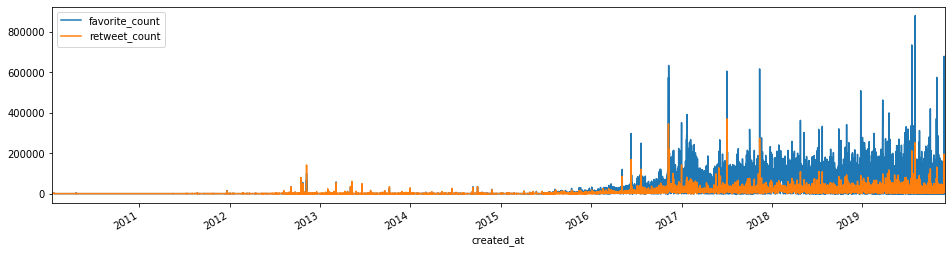

In [14]:
# Likes vs retweets visualization:
%matplotlib inline
tfav.plot(figsize=(16,4), label="favorite_count", legend=True)
tret.plot(figsize=(16,4), label="retweet_count", legend=True);

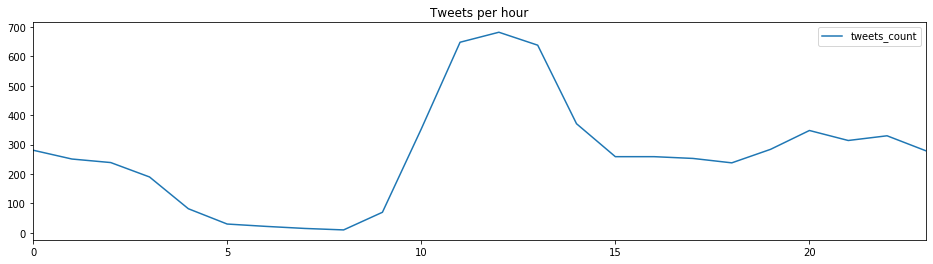

In [9]:
# what time of day the tweets occur
hours = list({t.hour for t in tfav.index})
temp = {}
for h in hours:
    c = 0
    for t in tfav['2016-11':'2018'].index:
        if t.hour == h:
            c += 1
    temp[h] = c
pd.Series(temp).plot(figsize=(16,4), label="tweets_count", legend=True, title='Tweets per hour');

In [15]:
# obtain all possible sources:
sources = list({source for source in df['source']})

# print sources list:
print("Creation of content sources:")
for source in sources:
    print("** {}".format(source))

Creation of content sources:
** Mobile Web (M5)
** Periscope
** Twitter Web App
** Twitter Web Client
** Media Studio
** Twitter for iPad
** Vine - Make a Scene
** Twitter for Android
** Twitter for BlackBerry
** Twitter QandA
** TweetDeck
** Twitter for iPhone
** Facebook
** Twitter for Websites
** Twitlonger
** Twitter Mirror for iPad
** Twitter Ads
** Twitter Media Studio
** Neatly For BlackBerry 10
** Instagram
** TwitLonger Beta


In [11]:
sources_fq = {s:len(df[df.source == s]) for s in sources}
sources_fq

{'Twitter Web Client': 12123,
 'Twitter for Websites': 1,
 'Neatly For BlackBerry 10': 5,
 'Twitter for Android': 14545,
 'Periscope': 7,
 'TwitLonger Beta': 405,
 'Twitter Mirror for iPad': 1,
 'Media Studio': 156,
 'Twitter Media Studio': 12,
 'TweetDeck': 483,
 'Facebook': 105,
 'Instagram': 133,
 'Twitter for iPad': 59,
 'Twitlonger': 23,
 'Twitter for BlackBerry': 97,
 'Mobile Web (M5)': 56,
 'Twitter for iPhone': 7923,
 'Vine - Make a Scene': 10,
 'Twitter QandA': 10,
 'Twitter Ads': 97}

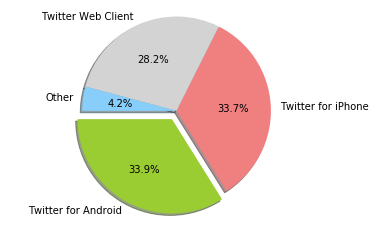

In [42]:
sources_fq = {s:len(df[df.source == s]) for s in sources}
sources_fq

# Pie charts of sources
count = 0
ms_dict = {}
for x,y in sources_fq.items():
    if x not in ['Twitter for Android', 'Twitter for iPhone', 'Twitter Web Client']:
        count += y
    else: ms_dict[x] = y
ms_dict['Other'] = count

import matplotlib.pyplot as plt
labels=sorted(ms_dict.keys(), key=lambda x:len(x),reverse=True)
sizes=sorted(ms_dict.values(),reverse=True)
colors=['yellowgreen','lightcoral','lightgray','lightskyblue']
explode=0.1,0,0,0

plt.pie(sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=180)
plt.axis('equal')
plt.show()

In [16]:
# tweets of different sources.
df_ad = df[df.source == 'Twitter for Android']
df_ip = df[df.source == 'Twitter for iPhone']
df_other = df[(df.source != 'Twitter for Android') & (df.source != 'Twitter for iPhone')]

In [17]:
def get_tweets_by_source(df_source):
    '''
    Function to know how many tweets are posted on different platforms each year.
    '''
    df_source.index = df_source.created_at
    result = {}
    for t in df_source.created_at:
        time = str(t)[:7]
        result[time] = len(df_source[time])

    return result

ad_tweets = get_tweets_by_source(df_ad)
ip_tweets = get_tweets_by_source(df_ip)
other_tweets = get_tweets_by_source(df_other)

In [51]:
from plotly.offline import plot 
import plotly.graph_objs as go

dataset = {'x':list(ip_tweets.keys()),
           'y1':list(ip_tweets.values()),
           'y2':list(ad_tweets.values()),
           'y3':list(other_tweets.values())}

title="main source of @realDonaldTrump tweets over time"
data_g = []
tr_y1 = go.Bar(
    x = dataset['x'],
    y = dataset['y1'],
    name = 'iPhone',
    marker=dict(
    color='lightgray'
)
)
data_g.append(tr_y1)
tr_y2 = go.Bar(
    x = list(ad_tweets.keys()),
    y = dataset['y2'],
    name = 'Android',
    marker=dict(
    color='yellowgreen'
)
)
data_g.append(tr_y2)

tr_y3 = go.Bar(
    x = list(other_tweets.keys()),
    y = dataset['y3'],
    name = 'Other',
    marker=dict(
    color='pink'
)
)
data_g.append(tr_y3)

layout = go.Layout(title=title, xaxis={'title':'Time'}, yaxis={'title':'Number of tweets'})
fig = go.Figure(data=data_g, layout=layout)
plot(fig, filename=title)

'main source of @realDonaldTrump tweets over time.html'

In [52]:
# Data Clean
# use TweetTokenizer to tokenise a Tweet Text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

def tokenizer_tweets(df):
    
    text = ''
    for t in df['text']:
        text += t
    tokens = [i.lower() for i in tknzr.tokenize(text)]
    
    return tokens

tokens = tokenizer_tweets(df)
print(len(tokens))
print(tokens[:20])

992533
['wishing', 'everyone', 'a', 'happy', ',', 'healthy', 'and', 'prosperous', 'new', 'year', '!', 'wishing', 'everyone', 'a', 'very', 'happy', 'holiday', 'season', '!', "don't"]


In [53]:
# remove stop words and other noise(links and special characters) to get clear tokens
from nltk.corpus import stopwords
import string

punctiuation = list(string.punctuation)
stop = stopwords.words('english') + punctiuation

def clear_tokens(tokens):
    
    tokens_cl = [t for t in tokens if (len(t) >= 3) 
                 and (not t.startswith(('#', '@')))
                 and (not t.startswith('http'))
                 and (t not in stop)
                 and (t[0].isalpha())]
    
    return tokens_cl

tokens_cl = clear_tokens(tokens)
print(len(tokens_cl))
print(tokens_cl[:20])

400084
['wishing', 'everyone', 'happy', 'healthy', 'prosperous', 'new', 'year', 'wishing', 'everyone', 'happy', 'holiday', 'season', 'forget', 'watch', 'larry', 'king', 'tonight', 'cnn', "he's", 'television']


In [54]:
from nltk import FreqDist

def get_top10_of(i, n=10):
    return FreqDist([t for t in tokens if t.startswith(i)]).most_common(n)

In [55]:
# top 10 mentions
get_top10_of('@')

[('@realdonaldtrump', 9396),
 ('@barackobama', 695),
 ('@foxnews', 637),
 ('@foxandfriends', 554),
 ('@apprenticenbc', 401),
 ('@whitehouse', 378),
 ('@cnn', 316),
 ('@mittromney', 288),
 ('@ivankatrump', 286),
 ('@seanhannity', 222)]

In [56]:
# top 10 hashtags
get_top10_of('#')

[('#trump2016', 869),
 ('#makeamericagreatagain', 519),
 ('#maga', 258),
 ('#celebapprentice', 221),
 ('#', 201),
 ('#celebrityapprentice', 149),
 ('#trump', 114),
 ('#americafirst', 102),
 ('#draintheswamp', 78),
 ('#trumpforpresident', 76)]

In [57]:
# Marks of different sources
df_temp = df[~df.is_retweet].copy() # only non-RTs
df_temp.index = df_temp.created_at
df_temp = df_temp['2015-06':'2018'] # after Trump formally announced his candidacy 

def get_marks_on_source(source):
    '''
    Function to gather the number of tweets marks on different sources
    '''
    results = {}
    link_counter = 0
    hashtag_counter = 0
    quote_counter = 0
    
    for t in df_temp[df_temp.source == source].text:
        if t.startswith('"'):
            quote_counter += 1
        for i in t.split(' '):
            if i.startswith('https'):
                link_counter += 1
                break
        for i in t.split(' '):
            if i.startswith('#'):
                hashtag_counter += 1
                break

        results['links'] = link_counter
        results['quotes'] = quote_counter
        results['hashtags'] = hashtag_counter
        
    return results

ad_case = get_marks_on_source('Twitter for Android')
ip_case = get_marks_on_source('Twitter for iPhone')

In [58]:
print(ad_case)
print(ip_case)

{'links': 384, 'quotes': 2399, 'hashtags': 684}
{'links': 2336, 'quotes': 74, 'hashtags': 1505}


In [60]:
from plotly.offline import plot 
import plotly.graph_objs as go

dataset = {'x':['links','quotes','hashtags'],
           'y1':list(ad_case.values()),
           'y2':list(ip_case.values()),}

title='''whether tweets start with a quotation mark (") or have links ('https') and hashtags('#')'''
data_g = []
tr_y1 = go.Bar(
    x = dataset['x'],
    y = dataset['y1'],
    name = 'Android',
    marker=dict(
    color='yellowgreen'
)
)
data_g.append(tr_y1)
tr_y2 = go.Bar(
    x = dataset['x'],
    y = dataset['y2'],
    name = 'iPhone',
    marker=dict(
    color='lightgray'
)
)
data_g.append(tr_y2)

layout = go.Layout(title=title, xaxis={'title':'Marks'}, yaxis={'title':'Number of tweets'})
fig = go.Figure(data=data_g, layout=layout)
plot(fig, filename=title)

'whether tweets start with a quotation mark (") or have links (\'https\') and hashtags(\'#\').html'

In [61]:
# wordcloud
# use the tokens of original tweets to draw a wordcloud
df_original = df[~df.is_retweet].copy()
df_original.index = df_original.created_at


tokens_original = clear_tokens(tokenizer_tweets(df_original['2015-6':'2018']))
print(len(tokens_original))

141049


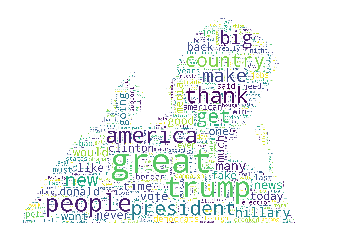

In [68]:
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt
from scipy.misc import imread
import imageio

bg_pic = imageio.imread('/Users/liuyang/Desktop/trump.jpg')
wc = WordCloud(background_color="white",
                      stopwords=stop,
                      mask=bg_pic,
                      scale=3,
                      max_words=2000,
                      max_font_size=100, 
                      random_state=42
                     ).generate_from_frequencies(FreqDist(tokens_original))

image_colors = ImageColorGenerator(bg_pic)

plt.imshow(wc)
plt.axis("off")
plt.show(wc.recolor(color_func=image_colors))

wc.to_file('/Users/liuyang/Desktop/trump.jpg')

In [69]:
# Sentiment Analysis
# textblob will allow us to do sentiment analysis in a very simple way
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Function to clean the text in a tweet by removing links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    #Function to classify sentiments of passed tweets using TextBlob's sentiment method
    analysis = TextBlob(clean_tweet(tweet))
    #set sentiments
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [70]:
df['sentiment'] = [get_tweet_sentiment(t) for t in df.text]

In [71]:
df.tail()

,created_at,favorite_ccount,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,sentiment
42920,2019-01-01 12:51:34,NaN,76622.0,1080084113762197504,NaN,False,14059,Twitter for iPhone,"Dr. Sebastian Gorka, a very good and talented ...",Positive
42921,2019-01-01 02:01:26,NaN,0.0,1079920504268562432,NaN,False,25861,Twitter for iPhone,RT @WhiteHouse: 2018 has been a year of histor...,Neutral
42922,2019-01-01 01:05:39,NaN,135209.0,1079906462753869824,NaN,False,28529,Twitter for iPhone,...Remember this. Throughout the ages some thi...,Positive
42923,2019-01-01 00:51:43,NaN,99239.0,1079902957938925568,NaN,False,22897,Twitter for iPhone,"The Democrats will probably submit a Bill, bei...",Neutral
42924,2019-01-01 00:40:26,NaN,104440.0,1079900120047603712,NaN,False,23882,Twitter for iPhone,MEXICO IS PAYING FOR THE WALL through the many...,Positive


In [72]:
# positive tweets sample
for t in df[df['sentiment'] == 'Positive'].text[:5]:
    print(t + '\n')

WIshing everyone a happy, healthy and prosperous New Year!

Wishing everyone a very Happy Holiday season!

Don't forget to watch Larry King tonight, CNN at 9 pm.  He's a television legend and a great friend. It's going to be a fantastic farewell.

I'll be appearing on Larry King Live for his final show, Thursday night at 9 p.m., CNN. Larry's been on TV for 25 years...

Those five hotels includeTrump International Hotel & Tower New York, Trump Soho New York, Trump International Hotel & Tower Chicago...



In [73]:
# negative tweets sample
for t in df[df['sentiment'] == 'Negative'].text[-5:]:
    print(t + '\n')

We are working hard at the Border, but we need a WALL!  In 2018, 1.7 million pounds of narcotics seized, 17,000 adults arrested with criminal records, and 6000 gang members, including MS-13, apprehended. A big Human Trafficking problem.

The Democrats could solve the Shutdown problem in a very short period of time. All they have to do is approve REAL Border Security (including a Wall), something which everyone, other than drug dealers, human traffickers and criminals, want very badly! This would be so easy to do!

Michael Pillsbury interviewed by @cvpayne: “They have the motive of making the President look bad – instead of President Trump being portrayed as a HERO. The first President to take China on, it’s 20 years overdue....

Sadly, there can be no REAL Border Security without the Wall!

“General” McChrystal got fired like a dog by Obama. Last assignment a total bust. Known for big, dumb mouth. Hillary lover! https://t.co/RzOkeHl3KV



In [74]:
# print percentages:
pos_tweets = df[(~df.is_retweet) & (df.sentiment == 'Positive')] 
neu_tweets = df[(~df.is_retweet) & (df.sentiment == 'Neutral')]                                                                   
neg_tweets = df[(~df.is_retweet) & (df.sentiment == 'Negative')]  
                                                                        
print("Percentage of positive tweets: %.2f%%" %(len(pos_tweets)*100/len(df[(~df.is_retweet)])))
print("Percentage of neutral tweets: %.2f%%" %(len(neu_tweets)*100/len(df[(~df.is_retweet)])))
print("Percentage of negative tweets: %.2f%%" %(len(neg_tweets)*100/len(df[(~df.is_retweet)])))

Percentage of positive tweets: 55.52%
Percentage of neutral tweets: 26.58%
Percentage of negative tweets: 17.89%


In [75]:
# use the tokens of original tweets to draw a wordcloud
df_original = df[~df.is_retweet].copy()
df_original.index = df_original.created_at
tokens_original = clear_tokens(tokenizer_tweets(df_original['2015-6':'2018']))
# draw a positive wordcloud and a negative wordcloud
pos_tokens = [t for t in tokens_original if get_tweet_sentiment(t) == 'Positive']
neg_tokens = [t for t in tokens_original if get_tweet_sentiment(t) == 'Negative']

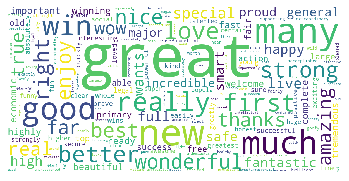

In [76]:
wc = WordCloud(background_color="white",
                      stopwords=stop,
                      scale=3,
                      max_words=2000,
                      max_font_size=70, 
                      random_state=200
                     ).generate_from_frequencies(FreqDist(pos_tokens))


plt.imshow(wc)
plt.axis("off")
plt.show(wc)

wc.to_file('/Users/liuyang/Desktop/trump_tweets_positive_wordcloud.png')

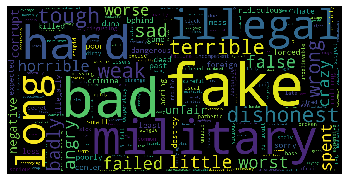

In [77]:
wc = WordCloud(background_color="black",
                      stopwords=stop,
                      scale=3,
                      max_words=2000,
                      max_font_size=70, 
                      random_state=100
                     ).generate_from_frequencies(FreqDist(neg_tokens))


plt.imshow(wc)
plt.axis("off")
plt.show(wc)

wc.to_file('/Users/liuyang/Desktop/trump_tweets_negative_wordcloud.png')